In [52]:
from functools import partial

import numpy as np
import pandas as pd
from statsmodels.formula import api as smf

from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

In [53]:
class DataGenerator:
    def __init__(
        self,
        surrogate_distribution: callable,
        non_surrogate_distribution: callable,
        treatment_effect: float = 0.0,
        decay_factor: float = 1.0,
        total_panel: int = 52,
        control_group: bool = True
    ):
        self.surrogate_distribution = surrogate_distribution
        self.non_surrogate_distribution = non_surrogate_distribution
        self.treatment_effect = treatment_effect
        self.decay_factor = decay_factor
        
        self.total_panel = total_panel
        self.is_treatment_group = not control_group

        self.treatment_effects = np.array([treatment_effect*np.exp(-decay_factor*i) for i in range(total_panel)])
    
    def generate_data(self, n_samples:int = 1000, n_surrogates: int = 4):

        surrogate_data = np.clip(self.surrogate_distribution(size=(n_samples, n_surrogates)), a_min=0, a_max=np.inf)
        non_surrogate_data = np.clip(self.non_surrogate_distribution(size=(n_samples, self.total_panel - n_surrogates)), a_min=0, a_max=np.inf)

        full_panel_data = np.hstack([surrogate_data, non_surrogate_data])
        full_panel_data = full_panel_data + self.treatment_effects
        unit_total = full_panel_data.sum(axis=1)
        
        data = (
            pd.DataFrame(
                data = np.hstack([full_panel_data, unit_total.reshape(-1, 1)]), 
                columns=[f"surrogate_{i}" for i in range(n_surrogates)] + [f'non_surrogate_{i}' for i in range(n_surrogates, self.total_panel)] + ['unit_total']
            )
            .assign(
                treatment = int(self.is_treatment_group),
            )
        )
        return data

In [54]:
control_dg = DataGenerator(
    surrogate_distribution=partial(np.random.normal, loc=0, scale=1),
    non_surrogate_distribution=partial(np.random.normal, loc=5, scale=1),
    treatment_effect=0,
    decay_factor=0,
    total_panel=5,
    control_group=False
)
control_dg.generate_data(n_samples=10, n_surrogates=2)

,surrogate_0,surrogate_1,non_surrogate_2,non_surrogate_3,non_surrogate_4,unit_total,treatment
0,0.824652,1.933757,4.771993,4.309623,4.238042,16.078066,1
1,0.987024,0.105313,4.904691,5.007824,5.424512,16.429363,1
2,0.000000,0.000000,5.437969,6.296972,2.479996,14.214937,1
3,0.407013,0.747621,4.360031,4.527141,6.388509,16.430316,1
4,1.066457,0.204597,4.089538,3.979987,3.425465,12.766044,1
5,0.000000,0.000000,4.302233,5.635974,4.533547,14.471753,1
6,0.000000,1.312764,4.283209,7.059784,4.855384,17.511141,1
7,0.754989,0.000000,5.798951,3.448864,5.085618,15.088422,1
8,0.000000,0.000000,6.042084,5.006881,5.145255,16.194220,1
9,0.022806,0.000000,7.083951,4.719561,5.910613,17.736931,1


In [55]:
def generate_train_data(
        n_samples=1000,
        n_surrogates: int = 6, 
        surrogate_dist:callable = partial(np.random.normal, loc=0, scale=1),
        non_surrogate_dist:callable = None
    ) -> pd.DataFrame:
    non_surrogate_dist = non_surrogate_dist or surrogate_dist
    dg = DataGenerator(
        treatment_effect=0.0,
        control_group=False,
        surrogate_distribution=surrogate_dist,
        non_surrogate_distribution=non_surrogate_dist
    )
    train_data = dg.generate_data(n_samples=n_samples, n_surrogates=n_surrogates)
    return train_data

def generate_test_data(
        n_samples:int = 1000, 
        treatment_effect:float=0.5, 
        decay_factor:float = 1, 
        n_surrogates: int = 6, 
        surrogate_dist:callable = partial(np.random.normal, loc=0, scale=1),
        non_surrogate_dist:callable = None
    ) -> pd.DataFrame:

    non_surrogate_dist = non_surrogate_dist or surrogate_dist
    dg_c = DataGenerator(
        treatment_effect=0.0, 
        control_group=True, 
        surrogate_distribution=surrogate_dist,
        non_surrogate_distribution=non_surrogate_dist
    )
    dg_t = DataGenerator(
        treatment_effect=treatment_effect,
        decay_factor=decay_factor, 
        control_group=False, 
        surrogate_distribution=surrogate_dist,
        non_surrogate_distribution=non_surrogate_dist
    )
    control_data = dg_c.generate_data(n_samples=n_samples // 2, n_surrogates=n_surrogates)
    treatment_data = dg_t.generate_data(n_samples=n_samples // 2, n_surrogates=n_surrogates)
    test_data = pd.concat([control_data, treatment_data])
    return test_data

def estimate_treatment_effect(data:pd.DataFrame, outcome_col:str, treatment_col:str, return_p_value:bool=False) -> float:
    model = smf.ols(f"{outcome_col} ~ {treatment_col}", data=data)
    result = model.fit()
    if return_p_value:
        return result.params[treatment_col], result.pvalues[treatment_col]
    else:
        return result.params[treatment_col]

def add_sim_fit(train_data:pd.DataFrame, test_data:pd.DataFrame,  outcome_col:str, n_surrogates:int = 6,) -> pd.DataFrame:
    model = smf.ols(f"{outcome_col} ~ {' + '.join([f'surrogate_{i}' for i in range(n_surrogates)])}", data=train_data)
    result = model.fit()
    aug_data = (
        test_data
        .assign(**{
            outcome_col: lambda df: result.predict(df)
        })
    )
    return aug_data

# Simulation loop

In [56]:
dist_space = [
    ('same as train', None),
    ('poisson 5', partial(np.random.poisson, lam=5)),
    ('multicat', partial(np.random.choice, a=[0, 1, 2], p=[0.75, 0.24, 0.01])),
    ('exponential 1', partial(np.random.exponential, scale=1)),
    ('normal 5 1', partial(np.random.normal, loc=5, scale=1)),
    ('uniform 10 20', partial(np.random.uniform, low=10, high=20)),
]
estimate_df_list = list()
for dist_name, dist in dist_space:
    observed_estimates = list()
    simulated_estimates = list()
    
    for i in range(1000):
        train_data = generate_train_data(n_samples=1000, n_surrogates=6)
        test_data = generate_test_data(n_samples=1000, treatment_effect=5, decay_factor=100, n_surrogates=6, non_surrogate_dist=dist)

        aug_data = add_sim_fit(train_data, test_data, 'unit_total', n_surrogates=6)

        observed_estimates.append(estimate_treatment_effect(test_data, 'unit_total', 'treatment', return_p_value=True))
        simulated_estimates.append(estimate_treatment_effect(aug_data, 'unit_total', 'treatment', return_p_value=True))

    observed_estimate_df = pd.DataFrame(observed_estimates, columns=['estimate', 'p_value'])
    simulated_estimate_df = pd.DataFrame(simulated_estimates, columns=['estimate', 'p_value'])
    full_estimate_df = (
        pd.merge(
            observed_estimate_df,
            simulated_estimate_df,
            left_index=True,
            right_index=True,
            suffixes=('_observed', '_simulated')
        )
        .assign(
            diff_estimates = lambda df: df['estimate_observed'] - df['estimate_simulated']
        )
        .assign(
            dist = dist_name
        )
    )

    estimate_df_list.append(full_estimate_df)

In [57]:
estimate_df = pd.concat(estimate_df_list)
estimate_df.head()

,estimate_observed,p_value_observed,estimate_simulated,p_value_simulated,diff_estimates,dist
0,5.566051,2.523971e-79,3.627573,3.814769e-225,1.938477,same as train
1,5.113975,6.168792e-73,5.354362,0.000000e+00,-0.240387,same as train
2,4.736693,2.500776e-59,4.676100,1.309501e-246,0.060593,same as train
3,4.547676,1.351004e-52,5.908258,8.457648e-306,-1.360582,same as train
4,4.861530,9.477779e-64,6.529438,0.000000e+00,-1.667908,same as train


/var/folders/lw/1r4_v9ts3f59z0_k4mt14nj40000gp/T/ipykernel_63456/1785969949.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)


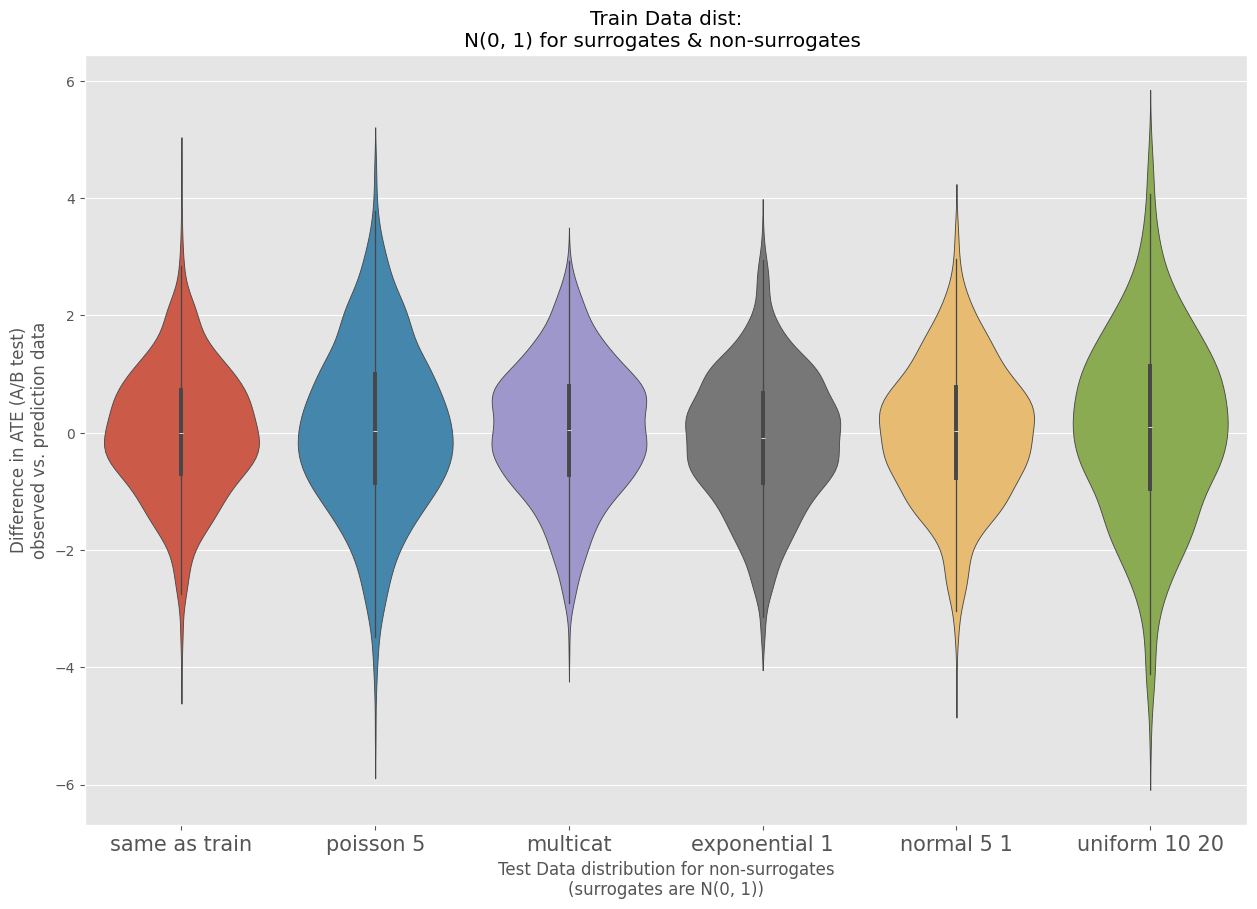

In [58]:
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.violinplot(
    data = estimate_df,
    hue = 'dist',
    x='dist',
    y='diff_estimates',
    split=False
)
ax.set_title('Train Data dist:\nN(0, 1) for surrogates & non-surrogates ')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)
ax.set_xlabel('Test Data distribution for non-surrogates\n(surrogates are N(0, 1))', fontsize=12)
ax.set_ylabel('Difference in ATE (A/B test)\nobserved vs. prediction data')

fig.savefig('../presentation/comparability_violation_comparison_1.png')

# Predicted vs Observed

In [62]:
dist_space = ('same as train', None)
treatment_effects = np.arange(0, 5.5, 0.5)
estimate_df_list = list()
for treatment_effect in treatment_effects:
    dist_name, dist = dist_space
    observed_estimates = list()
    simulated_estimates = list()
    
    for i in range(100):
        train_data = generate_train_data(n_samples=1000, n_surrogates=6)
        test_data = generate_test_data(n_samples=1000, treatment_effect=treatment_effect, decay_factor=100, n_surrogates=6, non_surrogate_dist=dist)

        aug_data = add_sim_fit(train_data, test_data, 'unit_total', n_surrogates=6)

        observed_estimates.append(estimate_treatment_effect(test_data, 'unit_total', 'treatment', return_p_value=True))
        simulated_estimates.append(estimate_treatment_effect(aug_data, 'unit_total', 'treatment', return_p_value=True))

    observed_estimate_df = pd.DataFrame(observed_estimates, columns=['estimate', 'p_value'])
    simulated_estimate_df = pd.DataFrame(simulated_estimates, columns=['estimate', 'p_value'])
    full_estimate_df = (
        pd.merge(
            observed_estimate_df,
            simulated_estimate_df,
            left_index=True,
            right_index=True,
            suffixes=('_observed', '_simulated')
        )
        .assign(
            diff_estimates = lambda df: df['estimate_observed'] - df['estimate_simulated']
        )
        .assign(
            dist = dist_name,
            treatment_effect = treatment_effect
        )
    )

    estimate_df_list.append(full_estimate_df)

In [63]:
estimate_df = pd.concat(estimate_df_list)
estimate_df.head()

,estimate_observed,p_value_observed,estimate_simulated,p_value_simulated,diff_estimates,dist,treatment_effect
0,0.600185,0.021157,0.037000,0.728554,0.563184,same as train,0.0
1,-0.498916,0.058267,0.047870,0.622950,-0.546786,same as train,0.0
2,-0.102750,0.701521,0.085378,0.359273,-0.188129,same as train,0.0
3,-0.074656,0.771654,-0.107109,0.261503,0.032453,same as train,0.0
4,-0.099969,0.704243,-0.149132,0.155382,0.049164,same as train,0.0


Text(0.5, 1.0, 'Non Surrogate Distribution\nTrain: N(0, 1) vs. Experiment: N(0, 1)')

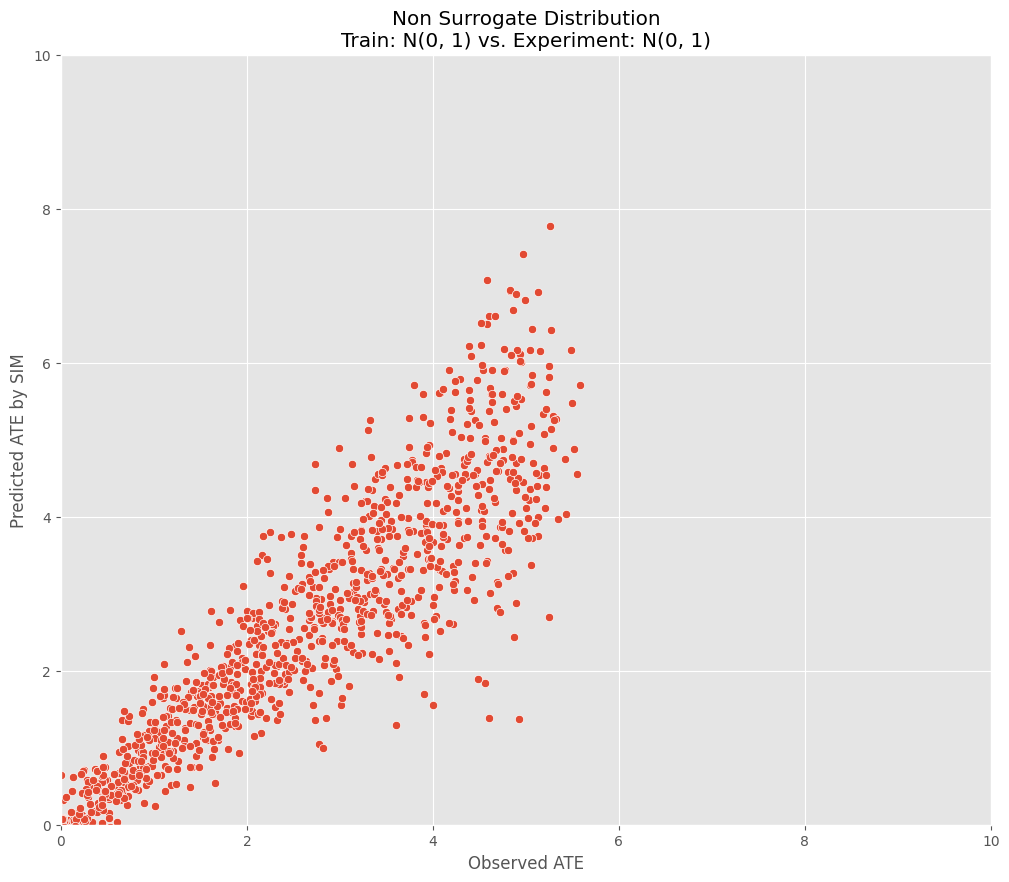

In [65]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(
    data = estimate_df.query('dist == "same as train"'),
    x='estimate_observed',
    y='estimate_simulated'
)
ax.set_xlabel('Observed ATE')
ax.set_ylabel('Predicted ATE by SIM')
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_title('Non Surrogate Distribution\nTrain: N(0, 1) vs. Experiment: N(0, 1)')

In [66]:
dist_space = ('uniform 10 20', partial(np.random.uniform, low=10, high=20))
treatment_effects = np.arange(0, 5.5, 0.5)
estimate_df_list = list()
for treatment_effect in treatment_effects:
    dist_name, dist = dist_space
    observed_estimates = list()
    simulated_estimates = list()
    
    for i in range(100):
        train_data = generate_train_data(n_samples=1000, n_surrogates=6)
        test_data = generate_test_data(n_samples=1000, treatment_effect=treatment_effect, decay_factor=100, n_surrogates=6, non_surrogate_dist=dist)

        aug_data = add_sim_fit(train_data, test_data, 'unit_total', n_surrogates=6)

        observed_estimates.append(estimate_treatment_effect(test_data, 'unit_total', 'treatment', return_p_value=True))
        simulated_estimates.append(estimate_treatment_effect(aug_data, 'unit_total', 'treatment', return_p_value=True))

    observed_estimate_df = pd.DataFrame(observed_estimates, columns=['estimate', 'p_value'])
    simulated_estimate_df = pd.DataFrame(simulated_estimates, columns=['estimate', 'p_value'])
    full_estimate_df = (
        pd.merge(
            observed_estimate_df,
            simulated_estimate_df,
            left_index=True,
            right_index=True,
            suffixes=('_observed', '_simulated')
        )
        .assign(
            diff_estimates = lambda df: df['estimate_observed'] - df['estimate_simulated']
        )
        .assign(
            dist = dist_name,
            treatment_effect = treatment_effect
        )
    )

    estimate_df_list.append(full_estimate_df)

In [67]:
estimate_df = pd.concat(estimate_df_list)
estimate_df.head()

,estimate_observed,p_value_observed,estimate_simulated,p_value_simulated,diff_estimates,dist,treatment_effect
0,0.531557,0.674748,0.149399,0.112441,0.382158,uniform 10 20,0.0
1,0.398675,0.744770,-0.041918,0.632061,0.440593,uniform 10 20,0.0
2,-1.083230,0.367783,-0.211079,0.024226,-0.872151,uniform 10 20,0.0
3,0.595637,0.631525,-0.110558,0.197961,0.706195,uniform 10 20,0.0
4,0.546538,0.659098,-0.158991,0.129072,0.705529,uniform 10 20,0.0


Text(0.5, 1.0, 'Non Surrogate Distribution\nTrain: N(0, 1) vs. Experiment: U(10, 20)')

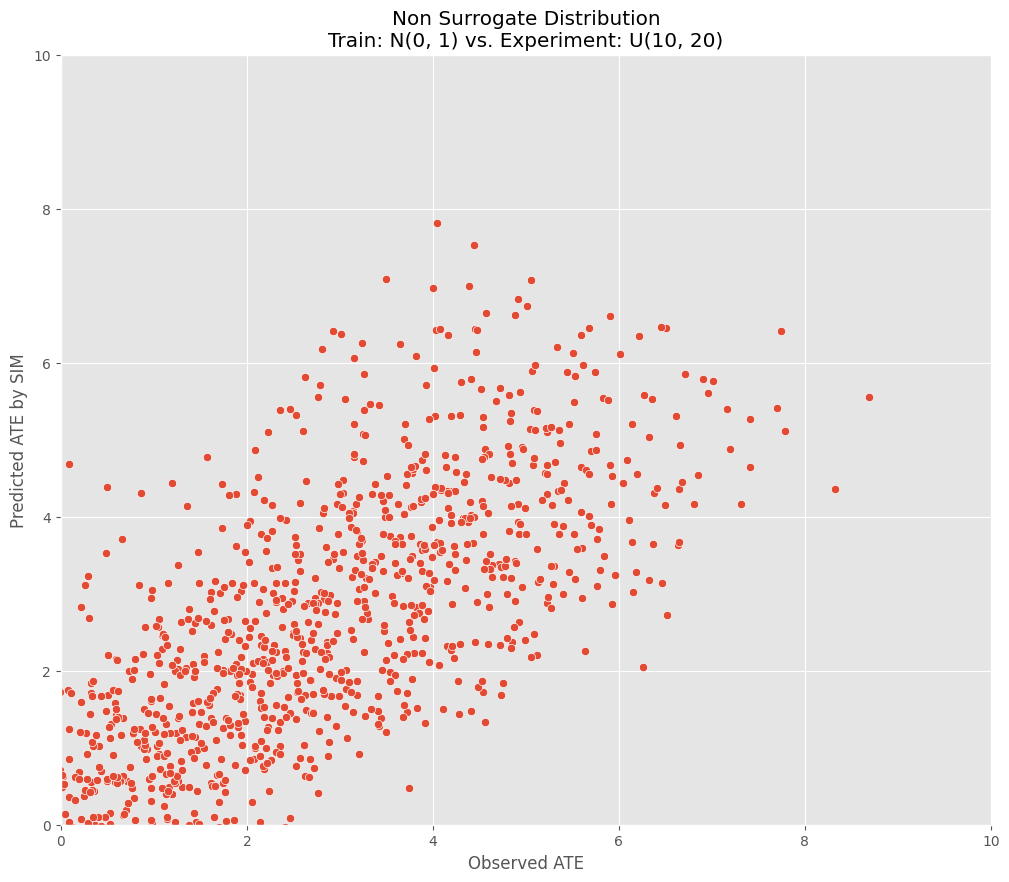

In [68]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(
    data = estimate_df,
    x='estimate_observed',
    y='estimate_simulated'
)
ax.set_xlabel('Observed ATE')
ax.set_ylabel('Predicted ATE by SIM')
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_title('Non Surrogate Distribution\nTrain: N(0, 1) vs. Experiment: U(10, 20)')

# Crazy shit

In [39]:
dist_space = [
    ('same as train', None),
    ('poisson 10', partial(np.random.poisson, lam=10)),
    ('binomial 15 0.3', partial(np.random.binomial, n=15, p=0.3)),
    ('exponential 10', partial(np.random.exponential, scale=10)),
    ('beta 1 5', partial(np.random.beta, a=1, b=5)),
    ('uniform 50 51', partial(np.random.uniform, low=50, high=51)),
]
estimate_df_list = list()
for dist_name, dist in dist_space:
    observed_estimates = list()
    simulated_estimates = list()
    
    for i in range(1000):
        train_data = generate_train_data(n_samples=1000, n_surrogates=6)
        test_data = generate_test_data(n_samples=1000, treatment_effect=5, decay_factor=100, n_surrogates=6, non_surrogate_dist=dist)

        aug_data = add_sim_fit(train_data, test_data, 'unit_total', n_surrogates=6)

        observed_estimates.append(estimate_treatment_effect(test_data, 'unit_total', 'treatment', return_p_value=True))
        simulated_estimates.append(estimate_treatment_effect(aug_data, 'unit_total', 'treatment', return_p_value=True))

    observed_estimate_df = pd.DataFrame(observed_estimates, columns=['estimate', 'p_value'])
    simulated_estimate_df = pd.DataFrame(simulated_estimates, columns=['estimate', 'p_value'])
    full_estimate_df = (
        pd.merge(
            observed_estimate_df,
            simulated_estimate_df,
            left_index=True,
            right_index=True,
            suffixes=('_observed', '_simulated')
        )
        .assign(
            diff_estimates = lambda df: df['estimate_observed'] - df['estimate_simulated']
        )
        .assign(
            dist = dist_name
        )
    )

    estimate_df_list.append(full_estimate_df)

In [40]:
crazy_estimate_df = pd.concat(estimate_df_list)
crazy_estimate_df.head()

,estimate_observed,p_value_observed,estimate_simulated,p_value_simulated,diff_estimates,dist
0,4.952520,2.054991e-67,5.427033,2.678959e-293,-0.474513,same as train
1,4.868074,1.151221e-65,5.346231,6.387637e-279,-0.478158,same as train
2,4.958009,1.765543e-65,4.381893,1.783228e-247,0.576117,same as train
3,5.130057,2.322743e-69,4.620240,4.505879e-321,0.509817,same as train
4,5.296551,1.347932e-79,5.757082,0.000000e+00,-0.460531,same as train


/var/folders/lw/1r4_v9ts3f59z0_k4mt14nj40000gp/T/ipykernel_63456/3406630875.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)


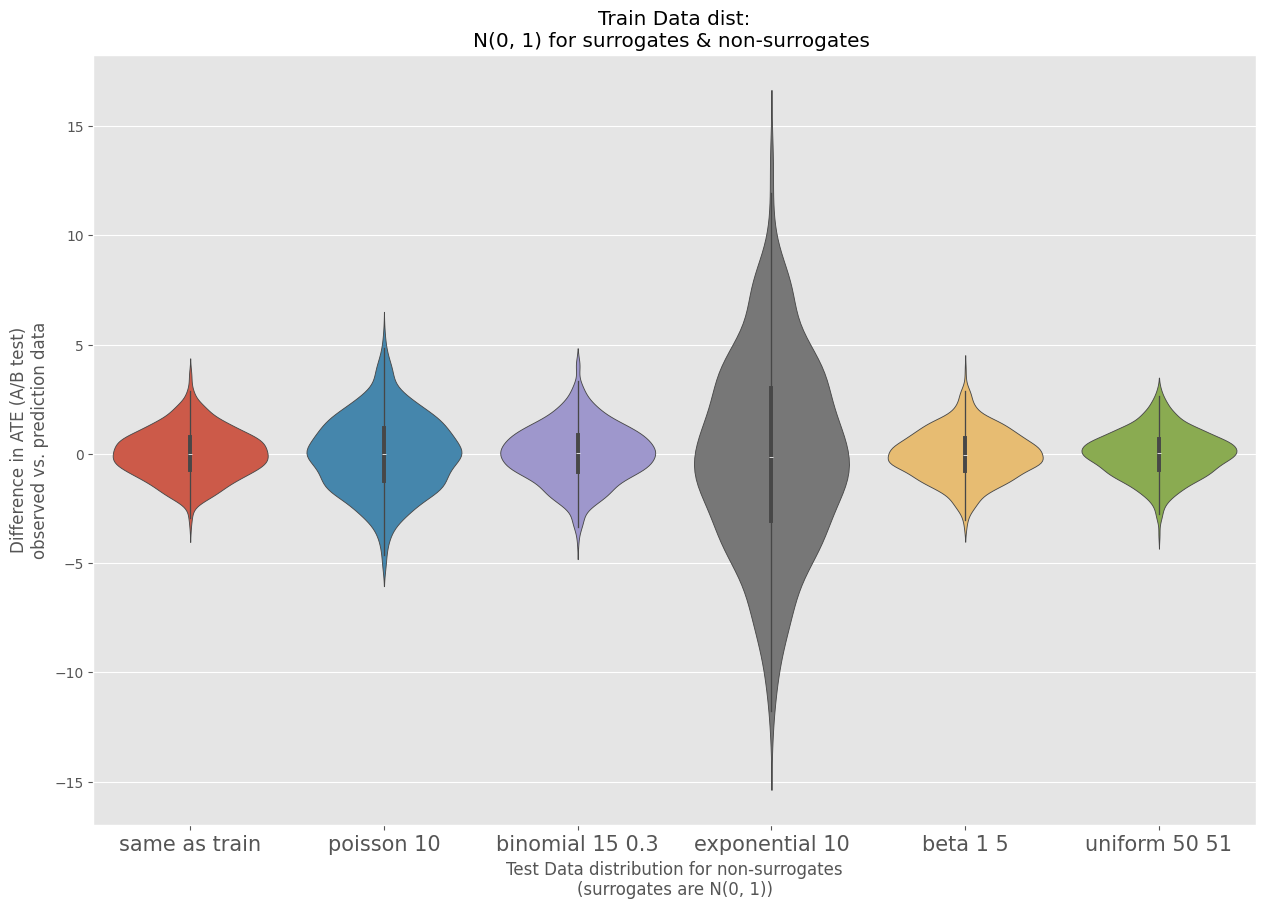

In [51]:
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.violinplot(
    data = crazy_estimate_df,
    hue = 'dist',
    x='dist',
    y='diff_estimates',
    split=False
)
ax.set_title('Train Data dist:\nN(0, 1) for surrogates & non-surrogates ')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)
ax.set_xlabel('Test Data distribution for non-surrogates\n(surrogates are N(0, 1))', fontsize=12)
ax.set_ylabel('Difference in ATE (A/B test)\nobserved vs. prediction data')
fig.savefig('../presentation/comparability_violation_comparison_2.png')

# Craziest shit

In [36]:
dist_space = [
    ('same as train', None),
    ('poisson 100', partial(np.random.poisson, lam=100)),
    ('exponential 100', partial(np.random.exponential, scale=100)),
    ('uniform 1 1000', partial(np.random.uniform, low=1, high=1000)),
]
estimate_df_list = list()
for dist_name, dist in dist_space:
    observed_estimates = list()
    simulated_estimates = list()
    
    for i in range(1000):
        train_data = generate_train_data(n_samples=1000, n_surrogates=6)
        test_data = generate_test_data(n_samples=1000, treatment_effect=5, decay_factor=100, n_surrogates=6, non_surrogate_dist=dist)

        aug_data = add_sim_fit(train_data, test_data, 'unit_total', n_surrogates=6)

        observed_estimates.append(estimate_treatment_effect(test_data, 'unit_total', 'treatment', return_p_value=True))
        simulated_estimates.append(estimate_treatment_effect(aug_data, 'unit_total', 'treatment', return_p_value=True))

    observed_estimate_df = pd.DataFrame(observed_estimates, columns=['estimate', 'p_value'])
    simulated_estimate_df = pd.DataFrame(simulated_estimates, columns=['estimate', 'p_value'])
    full_estimate_df = (
        pd.merge(
            observed_estimate_df,
            simulated_estimate_df,
            left_index=True,
            right_index=True,
            suffixes=('_observed', '_simulated')
        )
        .assign(
            diff_estimates = lambda df: df['estimate_observed'] - df['estimate_simulated']
        )
        .assign(
            dist = dist_name
        )
    )

    estimate_df_list.append(full_estimate_df)

In [37]:
craziest_estimate_df = pd.concat(estimate_df_list)

In [38]:
test_data

,surrogate_0,surrogate_1,surrogate_2,surrogate_3,surrogate_4,surrogate_5,non_surrogate_6,non_surrogate_7,non_surrogate_8,non_surrogate_9,...,non_surrogate_44,non_surrogate_45,non_surrogate_46,non_surrogate_47,non_surrogate_48,non_surrogate_49,non_surrogate_50,non_surrogate_51,unit_total,treatment
0,0.921549,0.000000e+00,8.870757e-01,0.000000e+00,2.181917e+00,0.000000e+00,682.041454,115.597387,566.712275,551.140903,...,389.137361,870.150191,636.701902,520.310913,925.994403,800.805461,68.969778,154.262743,22047.017393,0
1,1.676241,0.000000e+00,1.189877e-02,0.000000e+00,0.000000e+00,0.000000e+00,241.110146,489.296137,985.591145,717.178272,...,940.267468,70.642209,533.523082,493.077671,840.829143,631.637943,397.453213,857.336881,24932.926079,0
2,0.000000,0.000000e+00,0.000000e+00,9.923253e-01,1.839955e+00,3.529483e-01,765.743002,463.711860,585.976360,379.768374,...,322.365024,883.822122,221.116397,105.525814,81.678876,766.658943,537.816563,814.678954,25172.112225,0
3,0.670706,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,831.963446,977.623487,201.705975,613.918080,...,584.752624,129.067334,573.825899,262.806828,732.365480,26.216774,96.124947,295.444067,22161.870959,0
4,0.000000,0.000000e+00,5.433434e-01,2.370413e-01,3.331802e-01,1.708524e+00,47.780324,864.534386,422.904904,693.066432,...,348.563190,696.005743,138.342572,771.948545,253.996121,970.186664,114.620921,723.420628,24406.881584,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,5.000000,2.008770e-01,6.097774e-01,1.804499e-01,9.575848e-174,9.734689e-01,987.135437,583.477597,403.332539,780.164661,...,85.058221,839.897854,12.854046,382.015060,516.372278,954.568233,364.931790,224.433908,23222.557115,1
496,5.000000,1.860038e-43,3.136039e-01,3.088233e-01,4.653954e-01,3.562288e-217,621.454250,76.025702,675.542201,122.020067,...,403.925465,158.299479,87.376319,855.061976,284.958698,427.214057,408.024126,736.687777,23491.902950,1
497,7.062237,9.044979e-01,9.808163e-01,2.574100e-130,9.575848e-174,3.562288e-217,782.369567,462.407804,107.871490,94.691836,...,816.527047,943.970693,37.855671,775.495966,609.550569,902.087807,262.963587,756.956721,25248.231819,1
498,5.000000,2.797859e-01,1.596048e-01,5.361469e-01,9.575848e-174,3.562288e-217,549.367945,897.771279,537.833722,868.671400,...,805.691457,612.236059,17.893414,958.515241,426.388926,419.982878,737.770964,583.412562,27113.451920,1


/var/folders/lw/1r4_v9ts3f59z0_k4mt14nj40000gp/T/ipykernel_63456/534730274.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)


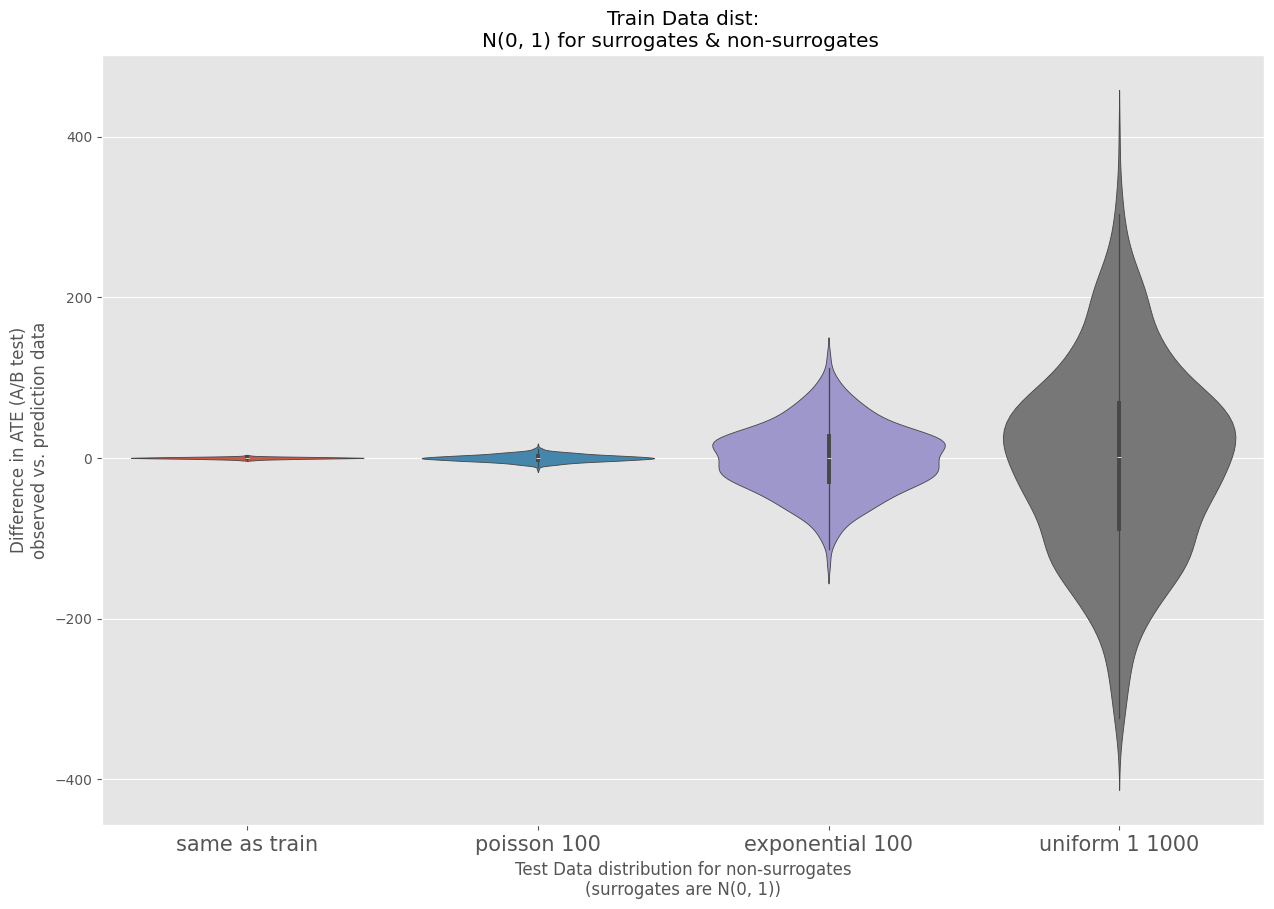

In [50]:
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.violinplot(
    data = craziest_estimate_df,
    hue = 'dist',
    x='dist',
    y='diff_estimates',
    split=False
)
ax.set_title('Train Data dist:\nN(0, 1) for surrogates & non-surrogates ')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)
ax.set_xlabel('Test Data distribution for non-surrogates\n(surrogates are N(0, 1))', fontsize=12)
ax.set_ylabel('Difference in ATE (A/B test)\nobserved vs. prediction data')
fig.savefig('../presentation/comparability_violation_comparison_3.png')